# Personalized Medicine: Redefining Cancer Treatment
### Predict the effect of Genetic Variants to enable Personalized Medicine
##### https://www.kaggle.com/c/msk-redefining-cancer-treatment
- 임상 결과를 바탕으로 암의 돌연변이를 일으키는 유전적 요인을 분석하는 프로젝트

[Data Import](#Data-Import)  
[EDA](#EDA)  
[TF-IDF](#TF-IDF)  
[Evaluation Model](#Evaluation-Model)

In [3]:
import numpy as np # Linear Algebra
import pandas as pd # Data Processing
from pandas import HDFStore
import matplotlib.pyplot as plt # Visualize
%matplotlib inline
import seaborn as sns # Visualize
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS, CountVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import log_loss, accuracy_score
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import re
import nltk

# Data Import

In [4]:
train_text_df = pd.read_csv('data/training_text', sep="\|\|", engine="python", skiprows=1, names=["ID", "Text"])
test_text_df = pd.read_csv('data/test_text', sep="\|\|", engine="python", skiprows=1, names=["ID", "Text"])
train_vari_df = pd.read_csv('data/training_variants')
test_vari_df = pd.read_csv('data/test_variants')

In [5]:
train_vari_df.tail()

,ID,Gene,Variation,Class
3316,3316,RUNX1,D171N,4
3317,3317,RUNX1,A122*,1
3318,3318,RUNX1,Fusions,1
3319,3319,RUNX1,R80C,4
3320,3320,RUNX1,K83E,4


In [6]:
train_text_df.tail()

,ID,Text
3316,3316,Introduction Myelodysplastic syndromes (MDS) ...
3317,3317,Introduction Myelodysplastic syndromes (MDS) ...
3318,3318,The Runt-related transcription factor 1 gene (...
3319,3319,The RUNX1/AML1 gene is the most frequent targe...
3320,3320,The most frequent mutations associated with le...


##### 데이터 셋의 구성
- variation과 text set은 ID를 통해 연결되어 있다
- Gene: 돌연변이가 발생한 유전자
- Variation: 해당 돌연변이에 대한 아미노산 변화
- Class: 돌연변이의 분류(1~9 Class)
- Text: 돌연변이 분류의 근거가 되는 임상 기록
  
##### 분석의 목표
- Gene, Variation, Text를 통해 Class를 분류하는 것
- Class의 분류는 임상 결과인 Text를 기반으로 이뤄졌다고 한다
- 따라서 TF-IDF 등 text 분석 기법을 통해 Class를 분류할 필요가 있다고 판단됨

# EDA

7    953
4    686
1    568
2    452
6    275
5    242
3     89
9     37
8     19
Name: Class, dtype: int64

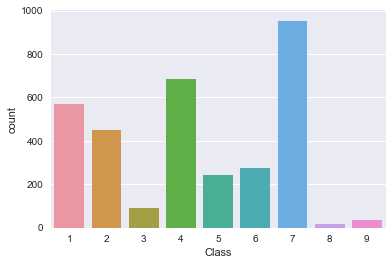

In [7]:
sns.countplot(x="Class", data=train_vari_df)
train_vari_df.Class.value_counts()

In [8]:
gene_counts = train_vari_df.Gene.value_counts()
print(gene_counts.sort_values(ascending=False)[:10],'\n')
print(gene_counts.sort_values()[:10])
len(gene_counts)

BRCA1     264
TP53      163
EGFR      141
PTEN      126
BRCA2     125
KIT        99
BRAF       93
ERBB2      69
ALK        69
PDGFRA     60
Name: Gene, dtype: int64 

GLI1      1
RAD54L    1
RRAS2     1
STAG2     1
PPM1D     1
MYOD1     1
ATR       1
EIF1AX    1
ASXL1     1
HLA-B     1
Name: Gene, dtype: int64


264

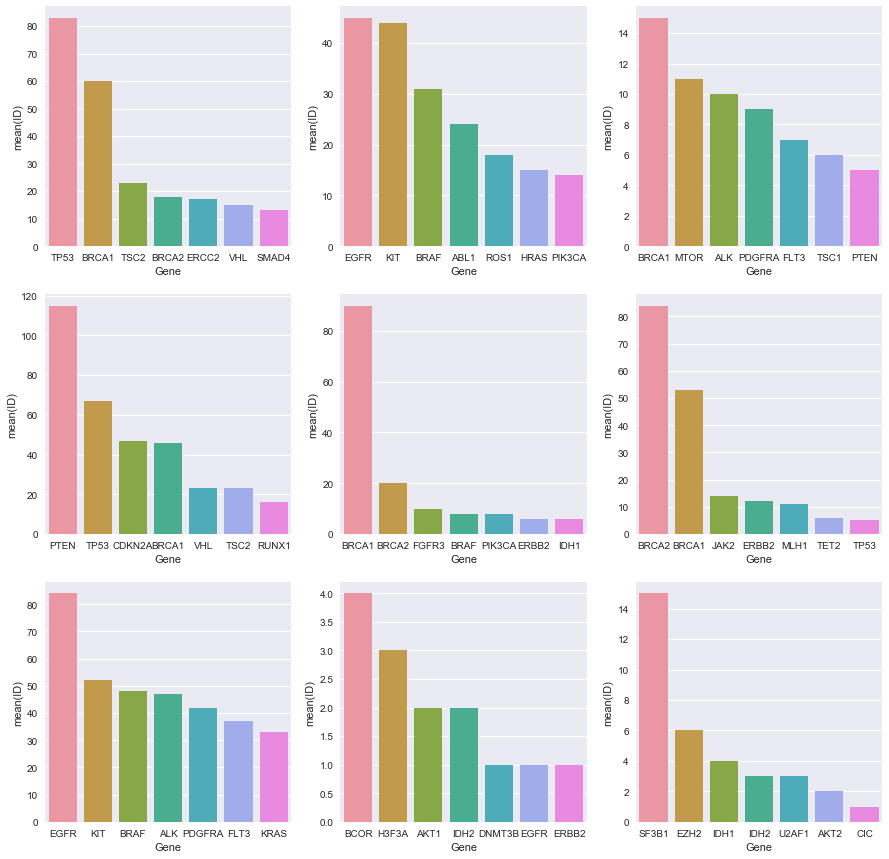

In [9]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(15,15))
for i in range(3):
    for j in range(3):
        gene_count_grp = train_vari_df[train_vari_df["Class"]==((i*3+j)+1)].groupby('Gene')["ID"].count().reset_index()
        sorted_gene_group = gene_count_grp.sort_values('ID', ascending=False)
        sorted_gene_group_top_7 = sorted_gene_group[:7]
        sns.barplot(x="Gene", y="ID", data=sorted_gene_group_top_7, ax=axs[i][j])

- BRCA1 은 Class1, 3, 5, 6 에서 많이 분포되어 있다.
- 특히 Class5 에서 BRCA1 이 많은 비율을 차지한다.
- BRCA1과 2는 비슷한 분포를 보인다.
- Class2, 7, 8, 9 에서는 BRCA의 비중이 작은 것으로 판단된다.
- TP53은 2번째로 많은 Gene이지만, Class1, 4 에서 유의미한 비중을 가지는 것으로 보인다.
- EGFR은 KIT과 상관도가 높은 것으로 보이며, Class 2, 7 을 분류하는 데 유의미 할 것으로 판단된다.
- SF3B1 은 Class9 에서 큰 비중을 차지한다.

In [10]:
Vari_counts = train_vari_df.Variation.value_counts()
print(Vari_counts.sort_values(ascending=False)[:10],'\n')
print(Vari_counts.sort_values()[:10],'\n')
len(Vari_counts)

Truncating Mutations    93
Deletion                74
Amplification           71
Fusions                 34
Overexpression           6
G12V                     4
E17K                     3
Q61H                     3
T58I                     3
Q61R                     3
Name: Variation, dtype: int64 

R574fs    1
L1854P    1
K2950N    1
L30F      1
N71K      1
Q367P     1
R82P      1
E627D     1
R420H     1
R133H     1
Name: Variation, dtype: int64 



2996

In [11]:
print(train_text_df.iloc[0,1])

Cyclin-dependent kinases (CDKs) regulate a variety of fundamental cellular processes. CDK10 stands out as one of the last orphan CDKs for which no activating cyclin has been identified and no kinase activity revealed. Previous work has shown that CDK10 silencing increases ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2)-driven activation of the MAPK pathway, which confers tamoxifen resistance to breast cancer cells. The precise mechanisms by which CDK10 modulates ETS2 activity, and more generally the functions of CDK10, remain elusive. Here we demonstrate that CDK10 is a cyclin-dependent kinase by identifying cyclin M as an activating cyclin. Cyclin M, an orphan cyclin, is the product of FAM58A, whose mutations cause STAR syndrome, a human developmental anomaly whose features include toe syndactyly, telecanthus, and anogenital and renal malformations. We show that STAR syndrome-associated cyclin M mutants are unable to interact with CDK10. Cyclin M silencing phenocopies CDK10

##### 변수의 구성
- **Class**
    - 본 분석에서 예측해야 할 데이터
    - 9개의 클래스 중 7번이 제일 많고 8번이 제일 적다
    - 항목당 차이가 크므로 Kfold 등을 사용하여 데이터가 치우치지 않도록 유의  
    
    
- **Gene**
    - 돌연변이가 발생한 유전자
    - 264종이며, 특정 Class에 분포되어 있는 Gene이 있는 것으로 보인다


- **Variation**
    - 돌연변이의 아미노산 변화
    - 2996종이며, 대부분 10개 이하로 이뤄져있다
    - Class 분류에 유의미하게 사용되기 어려울 것으로 판단된다
    
    
- **Text**
    - 돌연변이에 대한 관찰자료
    - 한 ID에 대해서도 상당한 양의 text가 존재함

In [12]:
# Dataframe 통합
df = train_vari_df.join(train_text_df.set_index('ID'), on='ID')
df_y = df['Class'].values
df_X = df[['Gene', 'Variation', 'Text']]
df_test = test_vari_df.join(test_text_df.set_index('ID'), on='ID')
df_test = df_test.iloc[:,1:]

In [13]:
df_new = pd.concat([df_X, df_test], ignore_index=True)

In [14]:
len(df_new)

8989

In [15]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8989 entries, 0 to 8988
Data columns (total 3 columns):
Gene         8989 non-null object
Variation    8989 non-null object
Text         8989 non-null object
dtypes: object(3)
memory usage: 210.8+ KB


# TF-IDF

In [16]:
vect = TfidfVectorizer()

In [17]:
stop_words = ENGLISH_STOP_WORDS

In [18]:
def text_Decomposition(text):
    text = re.sub(r"[^a-zA-Z0-9^,!./\+-_=]", " ", text) # 정규표현식 사용하여 ^이하가 아닌 것들은 제거
    text = text.lower().split()
    text = [i for i in text if not i in stop_words]
    text = " ".join(text)
    text = text.replace("."," ").replace(","," ")
    return (text)

In [19]:
df_new['Text'] = df_new['Text'].apply(text_Decomposition)

In [20]:
df_vect = vect.fit_transform(df_new['Text']).toarray()

In [21]:
svd = TruncatedSVD(n_components=200, n_iter=5, random_state=0)

In [22]:
truncated_tfidf = svd.fit_transform(df_vect)

In [23]:
df_tfidf = pd.DataFrame(truncated_tfidf)

In [24]:
df_tfidf.tail()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
8984,0.198822,-0.050257,0.012171,-0.089914,-0.004059,-0.027756,0.009028,-0.050974,0.080609,0.033433,...,0.005899,-0.024331,0.032314,-0.038275,-0.049983,0.038566,0.018327,-0.037981,-0.040497,0.044076
8985,0.168936,-0.042271,-0.007801,-0.062719,0.020268,-0.023328,-0.006039,-0.027310,0.033846,-0.007164,...,-0.001007,0.033268,-0.034676,0.018711,-0.005638,0.017241,-0.019900,0.058658,-0.002480,0.048007
8986,0.242678,-0.099755,-0.108291,0.137711,0.065636,0.127120,-0.129975,0.030754,-0.017880,-0.014541,...,0.003304,0.006046,0.010343,-0.016427,0.010360,0.006355,0.010233,0.042887,-0.017072,-0.015928
8987,0.163984,-0.025351,0.004394,-0.007817,0.021132,-0.008803,-0.003843,-0.003872,-0.000813,-0.000259,...,-0.008112,0.014183,0.016284,-0.012903,-0.022580,-0.013989,0.011560,0.035274,-0.000258,-0.027542
8988,0.169593,0.042018,0.020699,-0.015233,0.007866,-0.033753,-0.021334,0.048231,-0.030702,-0.012852,...,0.025991,0.026022,-0.000455,-0.007151,-0.004429,-0.052366,-0.008786,-0.007347,-0.022677,0.001323


# Dummificatoin

In [25]:
encoder = LabelEncoder()

In [27]:
df_dummy = df_new.iloc[:,:2]
df_dummy['Gene'] = encoder.fit_transform(df_dummy['Gene'])
df_dummy['Variation'] = encoder.fit_transform(df_dummy['Variation'])

/Users/mac/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/mac/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [28]:
df_dummy.tail()

,Gene,Variation
8984,1262,5379
8985,486,3684
8986,576,5892
8987,314,2785
8988,344,7542


# Join TF-IDF with Dummies

In [29]:
df_dummy['tmp'] = [i for i in range(len(df_new))]
df_tfidf['tmp'] = [i for i in range(len(df_tfidf))]

In [30]:
df_new = df_dummy.join(df_tfidf.set_index("tmp"), on="tmp")

In [31]:
del df_new['tmp']

In [32]:
df_new.tail()

,Gene,Variation,0,1,2,3,4,5,6,7,...,190,191,192,193,194,195,196,197,198,199
8984,1262,5379,0.198822,-0.050257,0.012171,-0.089914,-0.004059,-0.027756,0.009028,-0.050974,...,0.005899,-0.024331,0.032314,-0.038275,-0.049983,0.038566,0.018327,-0.037981,-0.040497,0.044076
8985,486,3684,0.168936,-0.042271,-0.007801,-0.062719,0.020268,-0.023328,-0.006039,-0.027310,...,-0.001007,0.033268,-0.034676,0.018711,-0.005638,0.017241,-0.019900,0.058658,-0.002480,0.048007
8986,576,5892,0.242678,-0.099755,-0.108291,0.137711,0.065636,0.127120,-0.129975,0.030754,...,0.003304,0.006046,0.010343,-0.016427,0.010360,0.006355,0.010233,0.042887,-0.017072,-0.015928
8987,314,2785,0.163984,-0.025351,0.004394,-0.007817,0.021132,-0.008803,-0.003843,-0.003872,...,-0.008112,0.014183,0.016284,-0.012903,-0.022580,-0.013989,0.011560,0.035274,-0.000258,-0.027542
8988,344,7542,0.169593,0.042018,0.020699,-0.015233,0.007866,-0.033753,-0.021334,0.048231,...,0.025991,0.026022,-0.000455,-0.007151,-0.004429,-0.052366,-0.008786,-0.007347,-0.022677,0.001323


In [33]:
df_X = df_new.iloc[:3321, :]
df_test = df_new.iloc[3321:, :]

In [34]:
df_X.tail()

,Gene,Variation,0,1,2,3,4,5,6,7,...,190,191,192,193,194,195,196,197,198,199
3316,1155,960,0.170994,-0.045179,-0.006091,-0.041549,0.019134,0.006038,-0.025845,-0.006712,...,0.029858,-0.004515,-0.009273,0.006321,0.017608,-0.021651,-0.004416,-0.009811,0.050201,0.020839
3317,1155,56,0.118418,-0.036305,-0.007569,-0.047085,0.024706,0.005303,-0.014394,-0.011832,...,0.019044,-0.006402,-0.004416,0.001102,0.021279,-0.031287,-0.012949,-0.009896,0.046655,0.035799
3318,1155,2076,0.079269,-0.017337,-0.012927,-0.024166,0.019396,-0.003074,-0.015040,0.009089,...,0.003361,0.012723,0.002893,-0.003739,0.008072,0.007519,-0.023889,0.027695,-0.035896,-0.028588
3319,1155,6606,0.224643,-0.041521,-0.005897,-0.042677,0.030225,-0.019028,-0.028927,0.018905,...,0.001600,0.004003,0.012378,0.003872,-0.009251,0.000922,-0.010805,-0.010922,-0.008621,0.001714
3320,1155,3608,0.222270,-0.034662,0.000893,-0.041136,0.021086,-0.012114,-0.037148,0.013536,...,0.004554,0.013057,0.017967,0.011499,-0.005571,0.002607,-0.007335,-0.008379,-0.002223,0.001623


In [35]:
train_X, test_X, train_y, test_y = train_test_split(df_X, df_y, random_state=0)

# Evaluation Model

In [36]:
# Cross Validation
def model_cv(train, test, train_y, test_y, model, name):
    model.fit(train, train_y)
    print(name,': ',model.best_params_)
    pred_y = model.predict_proba(test)
    print('train score: {}'.format(model.score(train, train_y)))
    print('test score: {}'.format(model.score(test, test_y)))
    print('log loss: {}'.format(log_loss(test_y, pred_y)))
    print()

In [55]:
# Models 
def forest(train, test, train_y, test_y):
    param = [{'n_estimators': [50, 100, 300, 500],
              'max_features': ['sqrt', 'log2'],
              'min_samples_leaf': [1,5,10,50,100,200,500]
         }]
    model = GridSearchCV(RandomForestClassifier(n_jobs=-1, random_state=0), param, cv=StratifiedKFold(n_splits=3, random_state=0))
    name = 'Random forest'
    return model_cv(train, test, train_y, test_y, model, name)

def xgbc(train, test, train_y, test_y):
    param = [{'n_estimators': [100, 300, 500],
         'learning_rate': [0.1, 0.05, 0.01],}]
    model = GridSearchCV(XGBClassifier(), param, cv=StratifiedKFold(n_splits=3, random_state=0))
    name = 'XGBoost'
    return model_cv(train, test, train_y, test_y, model, name)

def svc(train, test, train_y, test_y):
    param = [{'kernel': ['rbf'],
         'gamma': [1e-3, 1e-4], 'C' : [1, 10, 100, 1000]},
            {'kernel' : ['linear'], 'C' : [1, 10, 100, 1000]}]
    model = GridSearchCV(SVC(probability=True), param, cv=StratifiedKFold(n_splits=3, random_state=0))
    name = 'SVC'
    return model_cv(train, test, train_y, test_y, model, name)

# Model selection

In [48]:
forest(train_X, test_X, train_y, test_y)

Random forest :  {'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 500}
train score: 1.0
test score: 0.6522262334536703
log loss: 1.3998616630362637



In [ ]:
xgbc(train_X, test_X, train_y, test_y)

In [ ]:
svc(train_X, test_X, train_y, test_y)

In [40]:
xgbc = XGBClassifier(learning_rate=0.05, n_estimators=500)
xgbc.fit(train_X, train_y)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.05, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=500, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

# Submit

In [41]:
pred = xgbc.predict_proba(df_test)

In [42]:
submit = pd.DataFrame(pred)

In [43]:
ID = pd.DataFrame([{"ID": i} for i, _ in enumerate(pred)])

In [44]:
submit.columns = ['class1', 'class2', 'class3', 'class4', 'class5', 'class6', 'class7', 'class8', 'class9']

In [45]:
submit = pd.concat([ID, submit], axis=1)
submit.tail()

,ID,class1,class2,class3,class4,class5,class6,class7,class8,class9
5663,5663,0.086353,0.105370,0.004124,0.613574,0.004524,0.014221,0.170646,0.000390,0.000798
5664,5664,0.289894,0.208420,0.001386,0.069881,0.024722,0.007185,0.394951,0.001024,0.002537
5665,5665,0.004605,0.724316,0.000951,0.002301,0.011298,0.009492,0.246399,0.000305,0.000333
5666,5666,0.177749,0.244878,0.003824,0.264708,0.021720,0.019980,0.265430,0.001602,0.000109
5667,5667,0.436995,0.005794,0.002636,0.488163,0.035536,0.016516,0.009598,0.003705,0.001055


In [46]:
submit.to_csv('data/submit_xgbc2.csv', index=False)